# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

A last additional dataset for the second question of the project
https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml
Total of imports of agriculture, forestry and fishing goods


In [1]:
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import timedelta
import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
DATA_FOLDER = 'data'
openfood_file = "/en.openfoodfacts.org.products.csv"
temp_file = 'output/temp.csv'
countries_mapping_file = '/mapping_countries_revised.csv'
cleaned_off_dataset = 'output/cleaned_off.csv'

# Loading data

In [3]:
dataset_main = spark.read.csv(DATA_FOLDER + openfood_file, header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, "
geo_tags_cols = " manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col + geo_tags_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)



## Data Cleaning and Preprocessing

In [4]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE countries_tags is not NULL AND manufacturing_places_tags is not NULL"
off_p_df = spark.sql(sql_filter)

off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
3(columns) * 68672(rows)


In [5]:
# Explode countries
off_p_df = off_p_df\
.withColumn('manufacturing_places_tags', F.explode_outer(F.split('manufacturing_places_tags', ',')))\
.withColumn('countries_tags', F.explode_outer(F.split('countries_tags', ',')))

# Remove "en:" occurances before name of each country in coutries_tags
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "en:", ""))

# Remove - in name of countries
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "-", " "))
off_p_df = off_p_df.withColumn('manufacturing_places_tags', F.regexp_replace('manufacturing_places_tags', "-", " "))

# Remove numbers from name of countries
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "\d+", ""))
off_p_df = off_p_df.withColumn('manufacturing_places_tags', F.regexp_replace('manufacturing_places_tags', "\d+", ""))

In [6]:
off_p_df.show(5)

+-------------+-------------------------+--------------+
|         code|manufacturing_places_tags|countries_tags|
+-------------+-------------------------+--------------+
|0000000020114|                   france|        france|
|0000000274722|                   france|        france|
|0000000290616|          brossard quebec|        canada|
|0000000394710|          brossard quebec|        canada|
|0000001071894|           united kingdom|united kingdom|
+-------------+-------------------------+--------------+
only showing top 5 rows



In [7]:
off_p_df = off_p_df.withColumn("countries", off_p_df["countries_tags"])
off_p_df = off_p_df.withColumn("manufacturing_places", off_p_df["manufacturing_places_tags"])
off_p_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)



In [8]:
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
5(columns) * 128781(rows)


In [9]:
# Clean countries
cleaned_countries= pd.read_csv(DATA_FOLDER + countries_mapping_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
cleaned_countries.tail()

,input,country_code
841,england,UK
842,scotland,UK
843,europe,EU
844,mexique,MX
845,hongrie,HU


In [10]:
seen = 0

In [12]:
interval = 501
if seen:
    off_p_df = spark.read.csv(temp_file, header=True)

# Clean countries using mapping_countries
for index, row in cleaned_countries.head(seen + interval).iterrows():
        if index < seen:
            continue
        if index%100 == 0:
            print(index)    
        off_p_df = off_p_df.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + str(row['input']) + "$", row['country_code']))
        off_p_df = off_p_df.withColumn('countries', F.regexp_replace('countries', "^" + str(row['input']) + "$", row['country_code']))
        seen = index

# Save Spark dataframe in the Parquet format
off_p_df.toPandas().to_csv(temp_file, index=False)

print("Seen: {0}".format(seen))

500
600
700
800
Seen: 845


In [13]:
off_p_df.show(10)

+-------------+-------------------------+--------------+---------+--------------------+
|         code|manufacturing_places_tags|countries_tags|countries|manufacturing_places|
+-------------+-------------------------+--------------+---------+--------------------+
|0000000020114|                   france|        france|       FR|                  FR|
|0000000274722|                   france|        france|       FR|                  FR|
|0000000290616|          brossard quebec|        canada|       CA|     brossard quebec|
|0000000394710|          brossard quebec|        canada|       CA|     brossard quebec|
|0000001071894|           united kingdom|united kingdom|       UK|                  UK|
|0000001938067|          brossard quebec|        canada|       CA|     brossard quebec|
|0000004302544|                 brossard|        canada|       CA|            brossard|
|0000004302544|                   quebec|        canada|       CA|              quebec|
|0000007020254|               et

In [14]:
print("Full GEO information data Size:\n{0}(columns) *{1}(rows)".format(off_p_df.count(),len(off_p_df.columns) ))

Full GEO information data Size:
128781(columns) *5(rows)


In [15]:
#filter europe countries - using FIPS country code
filter_EU ='AL|AN|AM|AU|AJ|BO|BE|BK|BU|HR|CY|EZ|DA|EN|FI|FR|GG|GM|GR|HU|IC|EI|IT|KZ|KV|LG|LS|LH|LU|MK|MT|MD|MN|YI|NL|NO|Pl|PO|RO|RS|SM|LO|SI|SP|SW|SZ|TU|UP|UK|VT'

In [16]:
# store products that are sold in european union (france as ct)
eu_sold_data = off_p_df.filter(off_p_df["countries"].rlike(filter_EU))
print("eu_sold data Size:\n{0}".format(eu_sold_data.count()))

eu_sold data Size:
119047


In [17]:
# store products that are sold in Switzerland- using FIPS country code
swiss_sold_data = off_p_df[off_p_df["countries"] == "SZ"]
print("swiss_sold data Size:\n{0}".format(swiss_sold_data.count()))

swiss_sold data Size:
3936


Now that the two datasets of products sold in the European Union, and products sold in Switzerland are created, the analysis for each one is done. The study is going to focus in the behavior of the "manufacturing place" of those products.

## Find the most important importers in Europe

In [19]:
# Find the most important importers in Europe
eu_sold_data.createOrReplaceTempView("eu_sold_data")
target_manufacture = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM eu_sold_data GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacture = target_manufacture.withColumnRenamed('count(manufacturing_places)' , 'Count')
print("Number of Importers:\n" + str(target_manufacture.count()))
target_manufacture.show(5)

Number of Importers:
10029
+--------------------+-----+
|manufacturing_places|Count|
+--------------------+-----+
|                  FR|45826|
|                  SP| 7604|
|                  GM| 4864|
|                  IT| 4505|
|                  SZ| 2672|
+--------------------+-----+
only showing top 5 rows



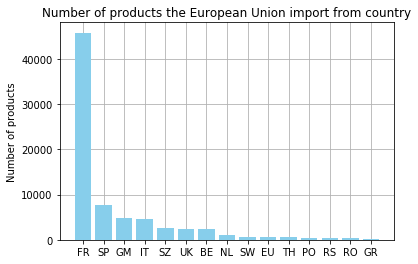

In [20]:
# Extract the 15 most important countries and number of occurances in ingredients.
manufacture_countries = target_manufacture.toPandas() 
manufacture_countries = manufacture_countries.head(15)

# Plot the number of products imported by 15 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacture_countries.manufacturing_places, manufacture_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacture_countries.manufacturing_places)
plt.title('Number of products the European Union import from country')
plt.show()

In [21]:
#Save all manufacturers in Europe
manufacture_countries.to_csv("output/europe_manufacturers.csv", index=False)

## Find the most important importers in Switzerland

In [22]:
# Find dominant importers of ingredients
swiss_sold_data.createOrReplaceTempView("swiss_sold_data")
target_swiss_manufacture = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM swiss_sold_data GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_swiss_manufacture = target_swiss_manufacture.withColumnRenamed('count(manufacturing_places)' , 'Count')
print("Number of Importers:\n" + str(target_swiss_manufacture.count()))
target_swiss_manufacture.show(5)

Number of Importers:
717
+--------------------+-----+
|manufacturing_places|Count|
+--------------------+-----+
|                  SZ| 1312|
|                  FR|  656|
|                  GM|  244|
|                  IT|  209|
|                  UK|   76|
+--------------------+-----+
only showing top 5 rows



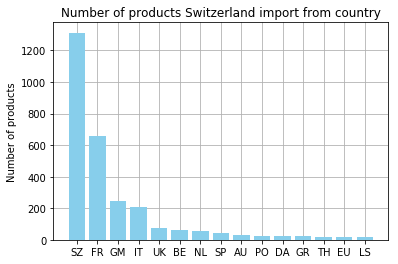

In [24]:
# Extract the 10 most important countries and number of occurances in ingredients.
manufacture_swiss_countries = target_swiss_manufacture.toPandas() 
manufacture_swiss_countries = manufacture_swiss_countries.head(15)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacture_swiss_countries.manufacturing_places, manufacture_swiss_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacture_swiss_countries.manufacturing_places)
plt.title('Number of products Switzerland import from country')
plt.show()

In [26]:
#Save all manufacturers in Switzerland
manufacture_swiss_countries.to_csv("output/switzerland_manufacturers.csv", index=False)

## Trade inside Europe

In [ ]:
eu_data = eu_sold_data.filter(eu_sold_data["manufacturing_places"].rlike(filter_EU))
print("Numbe of data about trade inside the Europe:\n{0}".format(eu_data.count()))

In [ ]:
eu_data.show(5)

### Generate the network of the trade inside Europe 

In [ ]:
eu_sold_df = eu_sold_data.toPandas()
swiss_sold_df = swiss_sold_data.toPandas()

## Principal categories of products

In order to have information about the categories, the dataset with categories is added

In [ ]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")

In [ ]:
eu_categories = eu_sold_data.join(categories_df, eu_sold_data.code == categories_df.code)
eu_categories.show(5)

In [ ]:
eu_categories.count()

In [ ]:
eu_categories.createOrReplaceTempView("eu_categories")
sql_filter = "SELECT * FROM eu_categories WHERE categories is not NULL"
eu_categories = spark.sql(sql_filter)

print("Number of Products sold in European Union with categories:\n" + str(eu_categories.count()))

In [ ]:
# Flatten categories column
eu_categories = eu_categories.withColumn('categories', F.explode_outer(F.split('categories', ',')))

In [ ]:
# Find dominant categories
eu_categories.createOrReplaceTempView("eu_categories")
eu_top_categories = spark.sql("SELECT categories, COUNT(categories) FROM eu_categories GROUP BY categories ORDER BY COUNT(categories) DESC")
eu_top_categories = eu_top_categories.withColumnRenamed('count(categories)' , 'Count')
eu_top_categories.show()

print("Number of Categories:\n" + str(eu_top_categories.count()))

As there are more than 18000 categories, it is decided to filter the products in order that they are classified just in 20 categories. 

TODO: Problem categories are the same name product

##### Second approach-WORKING

In [ ]:
#filter for identifying products from european countries
# Clean countries
cleaned_categories= pd.read_csv("cleaning_data/categories_db.csv",sep=',', error_bad_lines=False, encoding = "utf-8")
cleaned_categories.head()

In [ ]:
np.shape(cleaned_categories)

In [ ]:
#filter with 21 categories (with or structure)
cleaned_categories['filterCat'] = cleaned_categories['categories']
for i in range (0,len(cleaned_categories)):
    cleaned_categories['filterCat'][i] = cleaned_categories['categories'][i].replace(", ","|")

### European Union

In [ ]:
eu_categories_df = eu_categories.toPandas()

In [ ]:
for i in range (0,len(cleaned_categories)):
    cleaned_categories['Count'][i] = (eu_categories_df.product_name.str.contains(cleaned_categories['filterCat'][i],regex=True) | (eu_categories_df.categories.str.contains(cleaned_categories['filterCat'][i],regex=True))).sum() 
    print('Total products in category ',i," :",cleaned_categories['Count'][i])

In [ ]:
# Extract the 15 most frequent categories and number of occurances.
categories = cleaned_categories.sort_values(by='Count',ascending = False)#target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.category_main, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Number of products sold in European Union by category')
ax.invert_yaxis() 
plt.show()

No products with category for Bulgaria

In [ ]:
#Previous work

In [ ]:
eu_categories = eu_sold_data.join(categories_df, eu_sold_data.code == categories_df.code)
eu_categories.show(5)

In [ ]:
categories_df.show()

In [ ]:
eu_categories_df = eu_sold_data.join(categories_df, eu_sold_data.code == categories_df.code).toPandas()

In [ ]:
eu_categories_df.head(10)

Then the filters are formed

### European Union Countries

#### Belgique

In [ ]:
target_products_categories_p.show(5)

In [ ]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

In [ ]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

Filter for reducing number of categories, for a 20-categories one

In [ ]:
cleaned_categories = spark.read.csv("cleaning_data/categories_db.csv", header=True, mode="DROPMALFORMED", sep = ',')

In [ ]:
# Flatten categories column
cleaned_categories_p = cleaned_categories.withColumn('categories', F.explode_outer(F.split('categories', ',')))

In [ ]:
cleaned_categories_p.show(5)

In [ ]:
cleaned_categories = cleaned_categories_p.toPandas()

Now map categories of dataset to category_main

In [ ]:
seen = 0

In [ ]:
interval = 501
if seen:
    off_p_df = spark.read.csv(temp_file, header=True)

# Clean origins countries
for index, row in cleaned_categories.head(seen + interval).iterrows():
        if index < seen:
            continue
        if index%100 == 0:
            print(index)
        target_categories = target_categories.withColumn('category_main', F.regexp_replace('categories', "^" + str(row['categories']) + "$", row['category_main']))
        seen = index

# Save Spark dataframe in the Parquet format
#off_p_df.toPandas().to_csv(temp_file, index=False)

print("Seen: {0}".format(seen))

In [ ]:
target_categories.show(5)

In [ ]:
be_sold_data = off_p_df.filter(off_p_df["countries"].rlike('be'))
be_sold_data_df = be_sold_data.toPandas()

In [ ]:
openfood['code'] = pd.to_numeric(openfood['code'], errors='coerce')
be_sold_data_df['code'] = pd.to_numeric(be_sold_data_df['code'], errors='coerce')

In [ ]:
catBE = be_sold_data_df.join(openfood,on='code',how='left',lsuffix='eu',rsuffix='raw')['categories']

In [ ]:
new_df = off_p_df.join(be_sold_data, on=['code'], how='inner')

In [ ]:
new_df.count()

In [ ]:
new_df.show(10)

In [ ]:
Filer by category

In [ ]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

In [ ]:
eu_sold_data.createOrReplaceTempView("target_products_df")
categories_df.createOrReplaceTempView("categories_df")
joined_df = spark.sql("SELECT p.code, c.categories, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN categories_df c ON p.code = c.code")

In [ ]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

According to above table, 1096 products do not have any category. 

In [ ]:
joined_df.createOrReplaceTempView("target_products_cats")
sql_filter = "SELECT * FROM target_products_cats WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in European Union with categories:\n" + str(target_products_categories_p.count()))

In [ ]:
target_products_categories_p.show(5)

In [ ]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

In [ ]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

From above is seen that there are more than 9500 categories of aliments. For this reason, an additional categorization is made. Trying to map those 9742 categories to the most general 20 categories.

In [ ]:
raw_categories = target_categories.toPandas()

In [ ]:
raw_categories.head()

In [ ]:
cleaned_categories = pd.read_csv("cleaning_data/categories_db.csv")

In [ ]:
cleaned_categories['count_category'] = np.zeros(len(cleaned_categories))

In [ ]:
cleaned_categories['categories'][0]

In [ ]:
for i in range (0,len(raw_categories):
    if (raw_categories['categorires'][])
    cleaned_categories['categories'][i] = cleaned_categories['categories'][i]+raw_categories['Count'][i]

In [ ]:
# Extract the 15 most frequent categories and number of occurances.
categories = cleaned_categories#target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.category_main, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products sold in European Union')
ax.invert_yaxis() 
plt.show()

### Working with products' categories

We would like to find which countries import what products. In order to answer to this question, first we extract categories corresponding to the products sold in Switzerland but not manufactured in this country. Then we will combine the information provided for manufacturing places of these products with corresponding category. 

In the end we will extract the 5 most important importers of each category.

In [ ]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

In [ ]:
categories_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traces_df.columns]).show()

In [ ]:
# Join table of categories with table of target products (Sold in Switzerland but not manufactured in it)
non_swiss_sold.createOrReplaceTempView("target_products_df")
categories_df.createOrReplaceTempView("categories_df")
joined_df = spark.sql("SELECT p.code, c.categories, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN categories_df c ON p.code = c.code")

In [ ]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

According to above table, just 15 products do not have category. 

In [ ]:
joined_df.createOrReplaceTempView("target_products_cats")
sql_filter = "SELECT * FROM target_products_cats WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in Switzerland with categories:\n" + str(target_products_categories_p.count()))

In [ ]:
target_products_categories_p.show(5)

In [ ]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

In [ ]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

According to above table not all categories are independant and they may contain similar products. We did not change categories for this milestone but we would like to merge some categories in future to have better distinction between countries which import these products. 

In [ ]:
# Export Categories to CSV 
target_categories.toPandas().to_csv('output/categories.csv')

In [ ]:
# Extract the 15 most frequent categories and number of occurances.
categories = target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.categories, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products sold in Switzerland')
ax.invert_yaxis() 
plt.show()

In [ ]:
# Extract the most important manufacturer countries for 15 most frequent categories

categories_countires_p = target_products_categories_p.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))

# Clean manufacturers countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        categories_countires_p = categories_countires_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + row['origins'] + "$", row['replace_with']))
    else:
        categories_countires_p = categories_countires_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], "Not Specified"))

categories_countires_p = categories_countires_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))
products_cats_df = categories_countires_p.toPandas()

countries_cats = []
cat = "Snacks sucrés"
for index, row in categories.iterrows():
    temp_df = products_cats_df[(products_cats_df.categories == row.categories)].groupby('manufacturing_places').count().sort_values(by=['code'], ascending=False).head(5)
    countries_cats.append(temp_df)

# Each element of countries_cats is a dataframe containing the most important manufacturers
# of the corresponding category

i = 0
print("category: " + str(categories.iloc[i].categories))
print("The most important manufacturers:")
print(countries_cats[0].head(3).index.values)

We will use extracted information about the most important manufacturer countries for 15 most frequent categories for our visualization.